# Grafici QD e Difetto VS Intensità

## Preparazione e estrazione dati

In [213]:
from picchi import raccoglitore_2 # picchi reference
from varshni_subroutines import *
from math import sqrt

d_o_emi = ['emi=0', 'emi=0o5', 'emi=1', 'emi=1o5', 'emi=2', 'emi=2o5', 'emi=3']#, '3o5']
d_o_ass = ['ass=1', 'ass=0']
# dopo i 70K i qd scompaiono
arr_temperatura = [15, 30, 45]

medie = {}
fwhm = {}
intensità = {}

In [214]:
etichette_x = ["ass=1\nemi=0", 
               "ass=0\nemi=0.5", 
               "ass=0\nemi=1", 
               "ass=0\nemi=1.5", 
               "ass=0\nemi=2", 
               "ass=0\nemi=2.5", 
               "ass=0\nemi=3"]

In [215]:
for i, temp in enumerate(arr_temperatura):
    temp = str(temp)
    medie[temp] = {}
    fwhm[temp] = {}
    intensità[temp] = {}
    
    for ass in d_o_ass:
            
            medie[temp][ass] = {}
            fwhm[temp][ass] = {}
            intensità[temp][ass] = {}
            
            emi_list = d_o_emi[1:] if ass == 'ass=0' else ['emi=0']  # Per ass=1 usa solo emi='0'
            
            # Per ciascuno degli emi > 0 se ass=0, solo emi=0 se ass=1
            for emi in emi_list:
                
                medie[temp][ass][emi] = []
                fwhm[temp][ass][emi] = None
                intensità[temp][ass][emi] = None
                
                # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
                '''
                if len(raccoglitore_2[ass][emi][i]['Regione 1']) > 1:
                    picco_sx = raccoglitore_2[ass][emi][i]['Regione 1'][1][0]         
                    sigma_sx = raccoglitore_2[ass][emi][i]['Regione 1'][1][2]
                    int_sx = raccoglitore_2[ass][emi][i]['Regione 1'][1][3]
                else:
                    picco_sx, sigma_sx, int_sx = 0, 0, 0
                    
                if len(raccoglitore_2[ass][emi][i]['Regione 2']) > 1:
                    picco_dx = raccoglitore_2[ass][emi][i]['Regione 2'][1][0]
                    sigma_dx = raccoglitore_2[ass][emi][i]['Regione 2'][1][2]
                    int_dx = raccoglitore_2[ass][emi][i]['Regione 2'][1][3]
                else:
                    picco_dx, sigma_dx, int_dx = 0, 0, 0
                '''    
                # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
                # la regione di sx richiede attenzione particolare:
                # può capitare che ci sia un picco fittizio tra sx1 e sx2
                # può capitare anche che ci sia solo il picco sx2
                if len(raccoglitore_2[ass][emi][i]['Regione 1']) == 1:
                    if 747 < raccoglitore_2[ass][emi][i]['Regione 1'][0][0] < 800:
                        picco_sx = raccoglitore_2[ass][emi][i]['Regione 1'][0][0]
                        sigma_sx = raccoglitore_2[ass][emi][i]['Regione 1'][0][2]
                        int_sx = raccoglitore_2[ass][emi][i]['Regione 1'][0][3]
                    else:
                        picco_sx, sigma_sx, int_sx = 0, 0, 0
                elif len(raccoglitore_2[ass][emi][i]['Regione 1']) > 1:
                    # se sono tre allora c'è sicuramente il pezzotto in mezzo
                    if len(raccoglitore_2[ass][emi][i]['Regione 1']) == 3:
                        picco_sx = raccoglitore_2[ass][emi][i]['Regione 1'][2][0]
                        sigma_sx = raccoglitore_2[ass][emi][i]['Regione 1'][2][2]
                        int_sx = raccoglitore_2[ass][emi][i]['Regione 1'][2][3]
                    # se sono due si deve verificare che il secondo sia nel posto giusto
                    elif len(raccoglitore_2[ass][emi][i]['Regione 1']) == 2:
                        if 747 < raccoglitore_2[ass][emi][i]['Regione 1'][1][0] < 800:
                            picco_sx = raccoglitore_2[ass][emi][i]['Regione 1'][1][0]
                            sigma_sx = raccoglitore_2[ass][emi][i]['Regione 1'][1][2]
                            int_sx = raccoglitore_2[ass][emi][i]['Regione 1'][1][3]
                        else:
                            picco_sx, sigma_sx, int_sx = 0, 0, 0
                else:
                    picco_sx, sigma_sx, int_sx = 0, 0, 0
                    
                if len(raccoglitore_2[ass][emi][i]['Regione 2']) == 1:
                    picco_dx, sigma_dx, int_dx = 0, 0, 0
                elif len(raccoglitore_2[ass][emi][i]['Regione 2']) > 1:
                    picco_dx = raccoglitore_2[ass][emi][i]['Regione 2'][1][0]
                    sigma_dx = raccoglitore_2[ass][emi][i]['Regione 2'][1][2]
                    int_dx = raccoglitore_2[ass][emi][i]['Regione 2'][1][3]
                else:
                    picco_dx, sigma_dx, int_dx = 0, 0, 0
                # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
                
                # HACK: PROVO A METTERE ERRORE in nm 299.582/399 = 0,7508320802 nm cioè risoluzione apparato
                # mentre la versione precedente considera gli errori sui picchi forniti dal fitter
                err_picco_sx = err_lambda_to_E(picco_sx, 0.7508320802)
                err_picco_dx = err_lambda_to_E(picco_dx, 0.7508320802)
                
                # conversione dei nm in eV dei picchi
                picco_sx = lambda_to_E(picco_sx)
                picco_dx = lambda_to_E(picco_dx)  
                
                # conversione delle sigma in fwhm 
                # TODO: OCCHIO CHE SONO IN nm! PENSARE SE SI VOGLIONO METTERE IN eV
                fwhm_sx = sigma_sx * 2.35482004503 # 2*sqrt( 2*ln(2) )
                fwhm_dx = sigma_dx * 2.35482004503
                
                # calcolo intensità 
                A_sx = int_sx * sigma_sx * sqrt(2*np.pi)
                A_dx = int_dx * sigma_dx * sqrt(2*np.pi)
                
                # riempimento dei contenitori 
                medie[temp][ass][emi].append(picco_sx)
                medie[temp][ass][emi].append(err_picco_sx)
                medie[temp][ass][emi].append(picco_dx)
                medie[temp][ass][emi].append(err_picco_dx)
                
                fwhm[temp][ass][emi] = [fwhm_sx, fwhm_dx]
                
                intensità[temp][ass][emi] = [A_sx, A_dx]
                
                

In [216]:
medie['15']['ass=1']

{'emi=0': [np.float64(1.6326297286753046),
  np.float64(0.0016141670951221204),
  0,
  0]}

## Plot Energia su Intensità

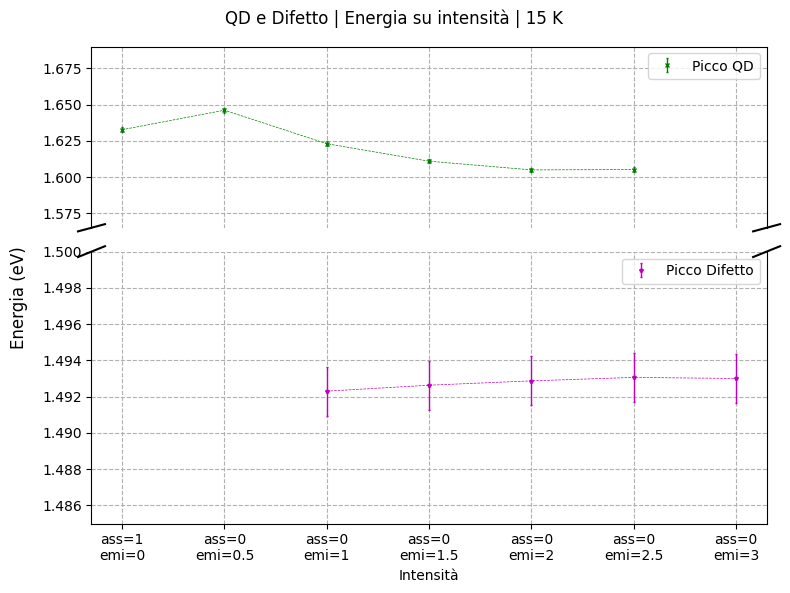

picco QD:
[np.float64(1.6326297286753046), np.float64(1.6460690628310126), np.float64(1.6229660777531325), np.float64(1.610907153079338), np.float64(1.6049073728291907), np.float64(1.605125365089546)]
errore picco QD:
[np.float64(0.0016141670951221204), np.float64(0.0016408511830014703), np.float64(0.0015951149095354369), np.float64(0.001571499000734642), np.float64(0.001559814788797419), np.float64(0.0015602385523740955)]
picco Difetto:
[np.float64(1.4923024544268924), np.float64(1.4926299961892349), np.float64(1.4928703375055727), np.float64(1.4930610605509524), np.float64(1.4930027631800706)]
errore picco Difetto:
[np.float64(0.001348611304768321), np.float64(0.0013492033764343526), np.float64(0.0013496379053169784), np.float64(0.0013499827758494472), np.float64(0.0013498773563027238)]


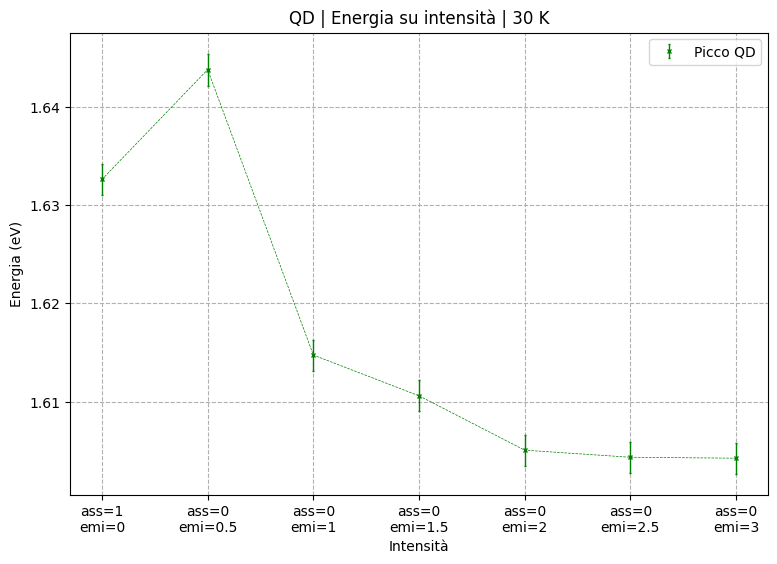

picco QD:
[np.float64(1.6326297286753046), np.float64(1.6438065533344164), np.float64(1.614749776297117), np.float64(1.6106017793046497), np.float64(1.6050669504983577), np.float64(1.604347258572484), np.float64(1.6042492793799805)]
errore picco QD:
[np.float64(0.0016141670951221204), np.float64(0.001636343607825569), np.float64(0.0015790051823320573), np.float64(0.0015709032505761974), np.float64(0.0015601249923484991), np.float64(0.0015587262249847226), np.float64(0.00155853584466329)]
picco Difetto:
[np.float64(1.4928439272905736)]
errore picco Difetto:
[np.float64(0.001349590153129711)]


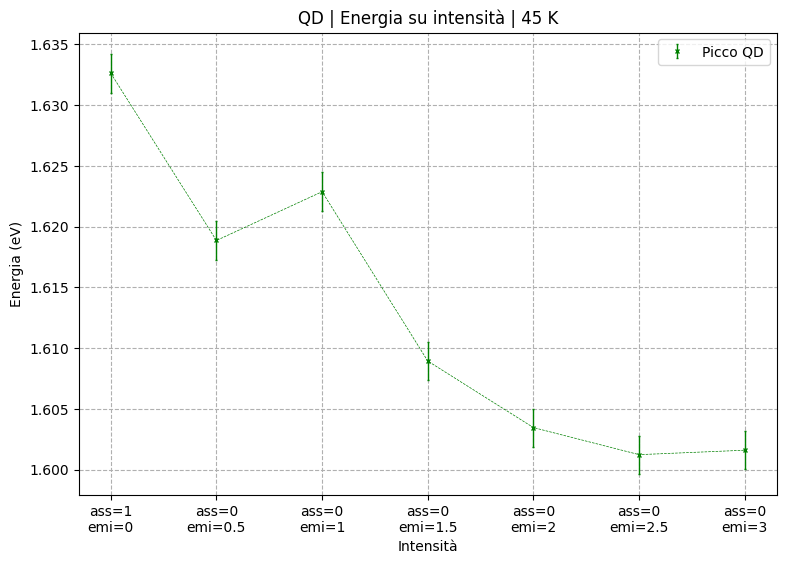

picco QD:
[np.float64(1.6326297286753046), np.float64(1.6188589185650537), np.float64(1.6228733168213725), np.float64(1.6089385430130188), np.float64(1.6034627582156973), np.float64(1.601236223070431), np.float64(1.6016023447875594)]
errore picco QD:
[np.float64(0.0016141670951221204), np.float64(0.0015870517696982887), np.float64(0.0015949325765602306), np.float64(0.0015676604450037843), np.float64(0.0015570080011430892), np.float64(0.001552686945226521), np.float64(0.0015533970683086725)]


In [217]:
for i, temp in enumerate(arr_temperatura):
    temp = str(temp)
    
    # picco sx 2
    x2 = []
    y2 = []
    err_y2 = []
    # picco dx 2
    x4 = []
    y4 = []
    err_y4 = []

    i = 1

    for ass in d_o_ass:
        emi_list = d_o_emi[1:] if ass == 'ass=0' else ['emi=0']  # Per ass=1 usa solo emi='0'
        
        # Per ciascuno degli emi > 0 se ass=0, solo emi=0 se ass=1
        for emi in emi_list:
            x2.append(i)
            x4.append(i)
        
            # picco sx 2
            y2.append(medie[temp][ass][emi][0])
            err_y2.append(medie[temp][ass][emi][1])
            
            # picco dx 2
            y4.append(medie[temp][ass][emi][2])
            err_y4.append(medie[temp][ass][emi][3])
            
            i += 1
            
    # vanno eliminati i punti con ordinata 0 (non è stato individuato il picco)
    x2 = [x_val for x_val, y_val in zip(x2, y2) if y_val != 0]
    y2 = [y_val for y_val in y2 if y_val != 0]
    err_y2 = [e_y_val for e_y_val in err_y2 if e_y_val != 0]

    x4 = [x_val for x_val, y_val in zip(x4, y4) if y_val != 0]
    y4 = [y_val for y_val in y4 if y_val != 0]
    err_y4 = [e_y_val for e_y_val in err_y4 if e_y_val != 0]
    
    # DOPO I 30K I DIFETTI SCOMPAIONO, NON C'È BISOGNO DI DUE GRAFICI
    if len(y4) < 2:
        plt.figure(figsize=(9, 6))
        plt.errorbar(x2, y2, yerr=err_y2, fmt='gx', label='Picco QD', markersize=3, elinewidth=1, capsize=1)
        plt.plot(x2, y2, linestyle='--', color='g', linewidth=0.5) # unisce i punti
        
        # Aggiungere etichette e legenda
        plt.title('QD | Energia su intensità | ' + temp + ' K')
        plt.xlabel('Intensità')
        plt.xticks(range(1, 8), etichette_x)
        plt.ylabel('Energia (eV)')
        plt.grid(linestyle='--')
        plt.legend()

        # Mostrare il grafico
        plt.show()

    else:
        # Creazione della figura
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [4, 6]}, figsize=(8, 6))

        # Plot superiore (range > 1.59)
        ax1.errorbar(x2, y2, yerr=err_y2, fmt='gx', label='Picco QD', markersize=3, elinewidth=1, capsize=1)
        ax1.plot(x2, y2, linestyle='--', color='g', linewidth=0.5) # unisce i punti
        ax1.errorbar(x4, y4, yerr=err_y4, fmt='m*', markersize=3, elinewidth=1, capsize=1)
        
        ax1.set_ylim(1.565, 1.690)  # Intervallo superiore
        ax1.spines['bottom'].set_visible(False)
        ax1.tick_params(bottom=False)
        ax1.grid(linestyle='--')

        # Plot inferiore (range < 1.54)
        ax2.errorbar(x2, y2, yerr=err_y2, fmt='gx', markersize=3, elinewidth=1, capsize=1)
        ax2.errorbar(x4, y4, yerr=err_y4, fmt='m*', label='Picco Difetto', markersize=3, elinewidth=1, capsize=1)
        ax2.plot(x4, y4, linestyle='--', color='m', linewidth=0.5) # unisce i punti
        ax2.set_ylim(1.485, 1.50)  # Intervallo inferiore
        ax2.spines['top'].set_visible(False)
        ax2.grid(linestyle='--')

        # Aggiunta della "scaletta" per indicare il break
        d = 0.02  # Distanza delle linee spezzate
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
        ax1.plot((-d, +d), (-d, +d), **kwargs)  # Linea spezzata in alto
        ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

        kwargs.update(transform=ax2.transAxes)
        ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Linea spezzata in basso
        ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

        # Etichette e titolo
        ax2.set_xlabel('Intensità')
        ax2.set_xticks(range(1, 8))
        ax2.set_xticklabels(etichette_x)
        ax1.legend()
        ax2.legend()
        fig.supylabel('Energia (eV)')
        fig.suptitle('QD e Difetto | Energia su intensità | ' + temp + ' K')

        # Mostrare il grafico
        plt.tight_layout()
        plt.show()

    # STAMPA DEI VALORI
    print ('picco QD:')
    print (y2)
    print ('errore picco QD:')
    print (err_y2)
    if len(y4) > 0:
        print ('picco Difetto:')
        print (y4)
        print ('errore picco Difetto:')
        print (err_y4)


## Plot FWHM su Intensità

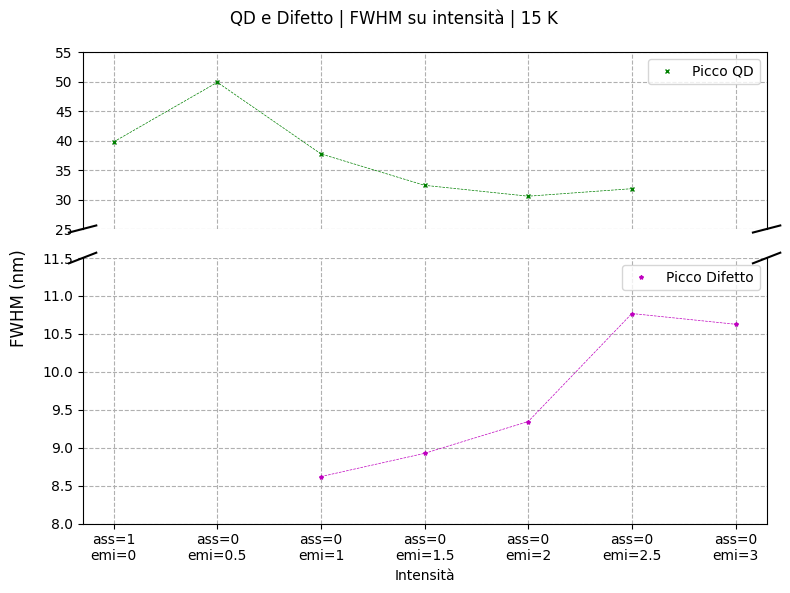

fwhm picco QD:
[np.float64(39.766974173206854), np.float64(49.86210909976343), np.float64(37.72931815256438), np.float64(32.403774125926816), np.float64(30.561365024123123), np.float64(31.834946090723186)]
fwhm picco Difetto:
[np.float64(8.618909461074324), np.float64(8.925206986736612), np.float64(9.34460006788049), np.float64(10.768106117713796), np.float64(10.626777521138433)]


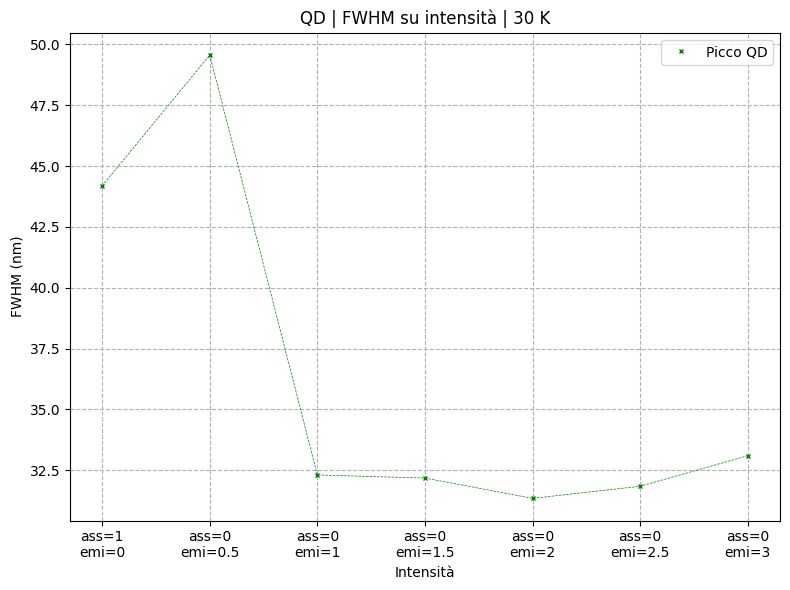

fwhm picco QD:
[np.float64(44.18763350487502), np.float64(49.56384878967623), np.float64(32.305350496123), np.float64(32.17831061639022), np.float64(31.34398059753131), np.float64(31.840615175392365), np.float64(33.096809528596474)]
fwhm picco Difetto:
[np.float64(16.88751346956914)]


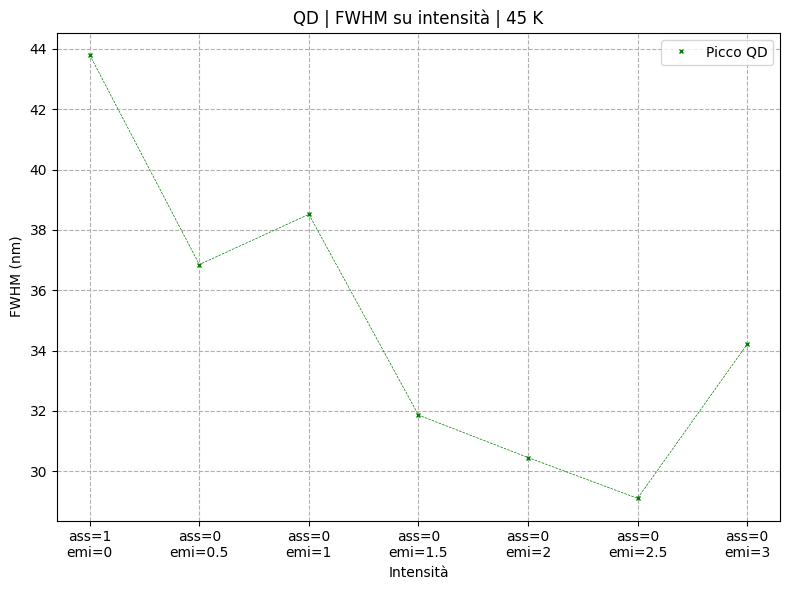

fwhm picco QD:
[np.float64(43.79839438066924), np.float64(36.851353782350834), np.float64(38.51654615332397), np.float64(31.86250425490045), np.float64(30.454895563611583), np.float64(29.101641452772167), np.float64(34.21174573606143)]


In [218]:
for i, temp in enumerate(arr_temperatura):
    temp = str(temp)
    
    # picco sx 2
    x2 = []
    y2 = []
    err_y2 = []
    # picco dx 2
    x4 = []
    y4 = []
    err_y4 = []

    i = 1

    for ass in d_o_ass:
        emi_list = d_o_emi[1:] if ass == 'ass=0' else ['emi=0']  # Per ass=1 usa solo emi='0'
        
        # Per ciascuno degli emi > 0 se ass=0, solo emi=0 se ass=1
        for emi in emi_list:
            x2.append(i)
            x4.append(i)
        
            # fwhm picco sx 2
            y2.append(fwhm[temp][ass][emi][0])
            # fwhm dx 2
            y4.append(fwhm[temp][ass][emi][1])
            
            i += 1
            
    # vanno eliminati i punti con ordinata 0 (non è stato individuato il picco)
    x2 = [x_val for x_val, y_val in zip(x2, y2) if y_val != 0]
    y2 = [y_val for y_val in y2 if y_val != 0]

    x4 = [x_val for x_val, y_val in zip(x4, y4) if y_val != 0]
    y4 = [y_val for y_val in y4 if y_val != 0]
    
    # DOPO I 30K I DIFETTI SCOMPAIONO, NON C'È BISOGNO DI DUE GRAFICI
    if len(y4) < 2:
        plt.figure(figsize=(8, 6))
        plt.errorbar(x2, y2, yerr=0, fmt='gx', label='Picco QD', markersize=3, elinewidth=0, capsize=0)
        plt.plot(x2, y2, linestyle='--', color='g', linewidth=0.5) # unisce i punti
        
        # Aggiungere etichette e legenda
        plt.title('QD | FWHM su intensità | ' + temp + ' K')
        plt.xlabel('Intensità')
        plt.xticks(range(1, 8), etichette_x)
        plt.ylabel('FWHM (nm)')
        plt.grid(linestyle='--')
        plt.legend()

        # Mostrare il grafico
        plt.tight_layout()
        plt.show()

    else:
        # Creazione della figura
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [4, 6]}, figsize=(8, 6))

        # Plot superiore (range > 1.59)
        ax1.errorbar(x2, y2, yerr=0, fmt='gx', label='Picco QD', markersize=3, elinewidth=0, capsize=0)
        ax1.plot(x2, y2, linestyle='--', color='g', linewidth=0.5) # unisce i punti
        ax1.errorbar(x4, y4, yerr=0, fmt='m*', markersize=3, elinewidth=0, capsize=0)
        
        ax1.set_ylim(25, 55)  # Intervallo superiore
        ax1.spines['bottom'].set_visible(False)
        ax1.tick_params(bottom=False)
        ax1.grid(linestyle='--')

        # Plot inferiore (range < 1.54)
        ax2.errorbar(x2, y2, yerr=0, fmt='gx', markersize=3, elinewidth=0, capsize=0)
        ax2.errorbar(x4, y4, yerr=0, fmt='m*', label='Picco Difetto', markersize=3, elinewidth=0, capsize=0)
        ax2.plot(x4, y4, linestyle='--', color='m', linewidth=0.5) # unisce i punti
        ax2.set_ylim(8, 11.5)  # Intervallo inferiore
        ax2.spines['top'].set_visible(False)
        ax2.grid(linestyle='--')

        # Aggiunta della "scaletta" per indicare il break
        d = 0.02  # Distanza delle linee spezzate
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
        ax1.plot((-d, +d), (-d, +d), **kwargs)  # Linea spezzata in alto
        ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

        kwargs.update(transform=ax2.transAxes)
        ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Linea spezzata in basso
        ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

        # Etichette e titolo
        ax2.set_xlabel('Intensità')
        ax2.set_xticks(range(1, 8))
        ax2.set_xticklabels(etichette_x)
        ax1.legend()
        ax2.legend()
        fig.supylabel('FWHM (nm)')
        fig.suptitle('QD e Difetto | FWHM su intensità | ' + temp + ' K')

        # Mostrare il grafico
        plt.tight_layout()
        plt.show()

    # STAMPA DEI VALORI
    print ('fwhm picco QD:')
    print (y2)
    if len(y4) > 0:
        print ('fwhm picco Difetto:')
        print (y4)


## Plot AREA PICCO su Intensità

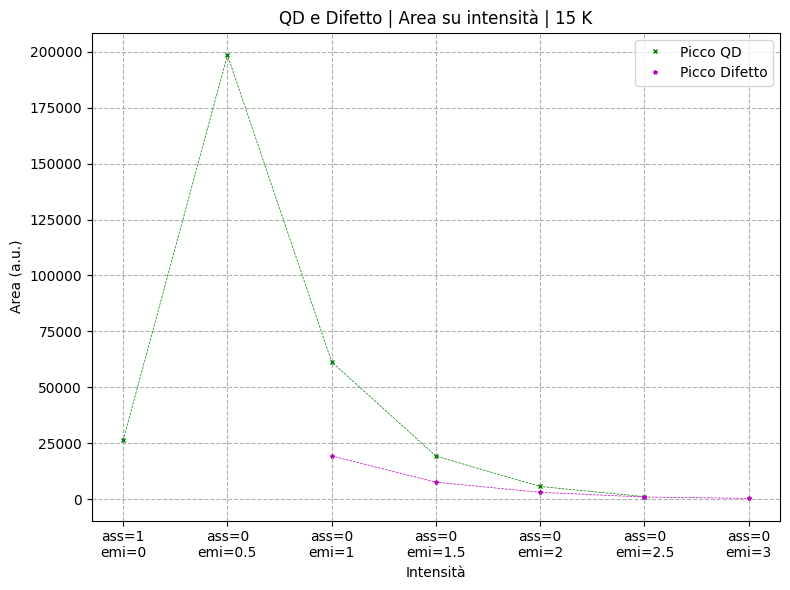

area picco QD:
[np.float64(26339.599604870647), np.float64(198623.53106964898), np.float64(61339.619073872054), np.float64(19204.563934870705), np.float64(5616.784792507021), np.float64(1062.2800994122251)]
area picco Difetto:
[np.float64(19265.726083228918), np.float64(7536.077497683349), np.float64(2988.8006184213027), np.float64(898.0416330094133), np.float64(303.01053741073923)]


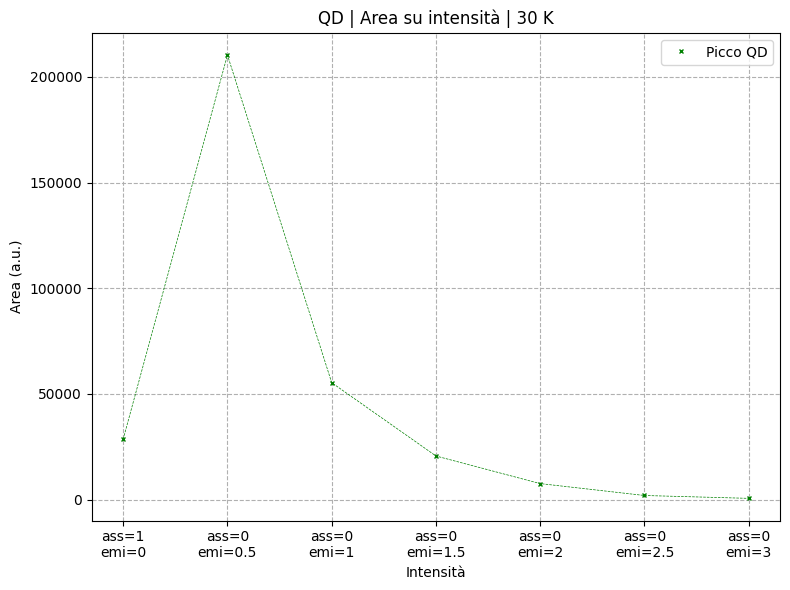

area picco QD:
[np.float64(28526.766296201033), np.float64(210340.63604337184), np.float64(55281.98800174617), np.float64(20593.81843064651), np.float64(7526.402022234796), np.float64(1896.4213764458086), np.float64(544.6898804369044)]
area picco Difetto:
[np.float64(221.7872937148124)]


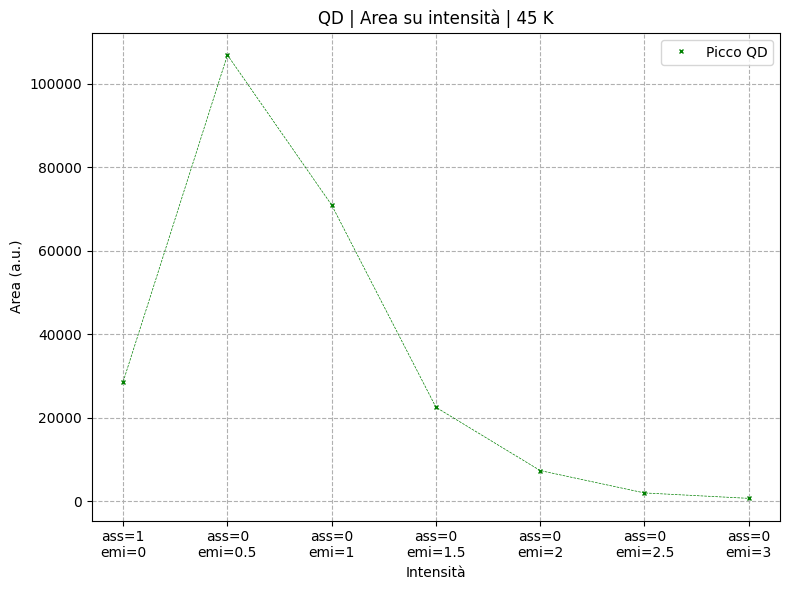

area picco QD:
[np.float64(28614.730499804948), np.float64(106877.18016118016), np.float64(70917.52019833232), np.float64(22465.771923420227), np.float64(7300.213779261058), np.float64(1941.963270931888), np.float64(643.9279078636183)]


In [219]:
## Plot Area su Intensità
for i, temp in enumerate(arr_temperatura):
    temp = str(temp)
    
    # picco sx 2
    x2 = []
    y2 = []
    err_y2 = []
    # picco dx 2
    x4 = []
    y4 = []
    err_y4 = []

    i = 1

    for ass in d_o_ass:
        emi_list = d_o_emi[1:] if ass == 'ass=0' else ['emi=0']  # Per ass=1 usa solo emi='0'
        
        # Per ciascuno degli emi > 0 se ass=0, solo emi=0 se ass=1
        for emi in emi_list:
            x2.append(i)
            x4.append(i)
        
            # fwhm picco sx 2
            y2.append(intensità[temp][ass][emi][0])
            # fwhm dx 2
            y4.append(intensità[temp][ass][emi][1])
            
            i += 1
            
    # vanno eliminati i punti con ordinata 0 (non è stato individuato il picco)
    x2 = [x_val for x_val, y_val in zip(x2, y2) if y_val != 0]
    y2 = [y_val for y_val in y2 if y_val != 0]

    x4 = [x_val for x_val, y_val in zip(x4, y4) if y_val != 0]
    y4 = [y_val for y_val in y4 if y_val != 0]
    
    # I VALORI SI SOVRAPPONGONO, NON SERVONO DUE GRAFICI 
    
    plt.figure(figsize=(8, 6))
    
    plt.errorbar(x2, y2, yerr=0, fmt='gx', label='Picco QD', markersize=3, elinewidth=0, capsize=0)
    plt.plot(x2, y2, linestyle='--', color='g', linewidth=0.5) # unisce i punti
    if len(y4)>1:
        plt.errorbar(x4, y4, yerr=0, fmt='m*', label='Picco Difetto', markersize=3, elinewidth=0, capsize=0)
        plt.plot(x4, y4, linestyle='--', color='m', linewidth=0.5) # unisce i punti
    
    # Aggiungere etichette e legenda
    if len(y4)>1:
        plt.title('QD e Difetto | Area su intensità | ' + temp + ' K')
    else:
        plt.title('QD | Area su intensità | ' + temp + ' K')
        
    plt.xlabel('Intensità')
    plt.xticks(range(1, 8), etichette_x)
    plt.ylabel('Area (a.u.)')
    plt.grid(linestyle='--')
    plt.legend()

    # Mostrare il grafico
    plt.tight_layout()
    plt.show()

    # STAMPA DEI VALORI
    print ('area picco QD:')
    print (y2)
    if len(y4) > 0:
        print ('area picco Difetto:')
        print (y4)
